In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load dataset
df = pd.read_csv(r"C:\Users\raksh\OneDrive\Desktop\Train.csv")
print("Dataset Shape:", df.shape)
df.info()

Dataset Shape: (10999, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [4]:
# Exploratory Data Analysis (EDA)
print("\nSummary Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())


Summary Statistics:
                 ID  Customer_care_calls  Customer_rating  Cost_of_the_Product  \
count  10999.00000         10999.000000     10999.000000         10999.000000   
mean    5500.00000             4.054459         2.990545           210.196836   
std     3175.28214             1.141490         1.413603            48.063272   
min        1.00000             2.000000         1.000000            96.000000   
25%     2750.50000             3.000000         2.000000           169.000000   
50%     5500.00000             4.000000         3.000000           214.000000   
75%     8249.50000             5.000000         4.000000           251.000000   
max    10999.00000             7.000000         5.000000           310.000000   

       Prior_purchases  Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
count     10999.000000      10999.000000   10999.000000         10999.000000  
mean          3.567597         13.373216    3634.016729             0.596691  
std        

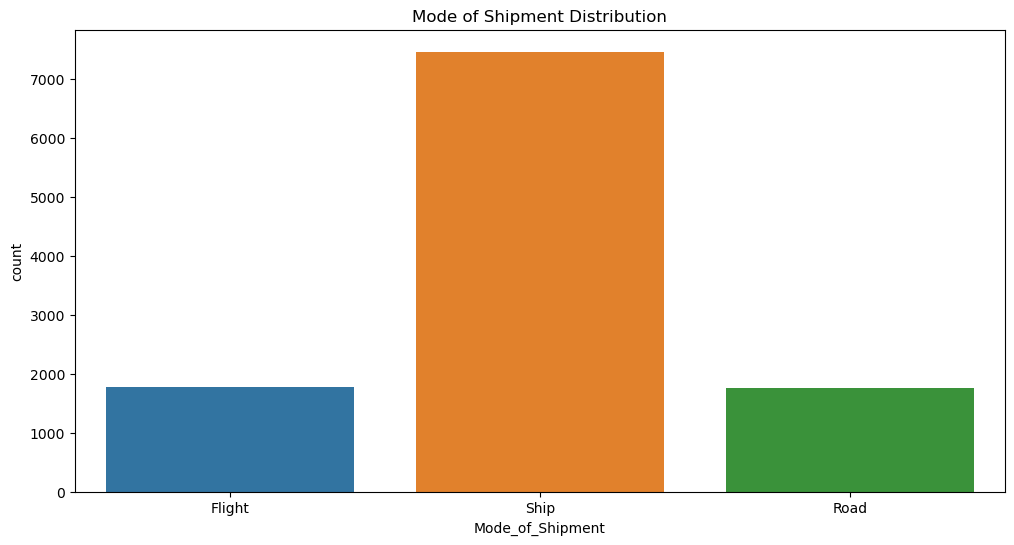

In [5]:
# Visualizations
plt.figure(figsize=(12, 6))
sns.countplot(x="Mode_of_Shipment", data=df)
plt.title("Mode of Shipment Distribution")
plt.show()

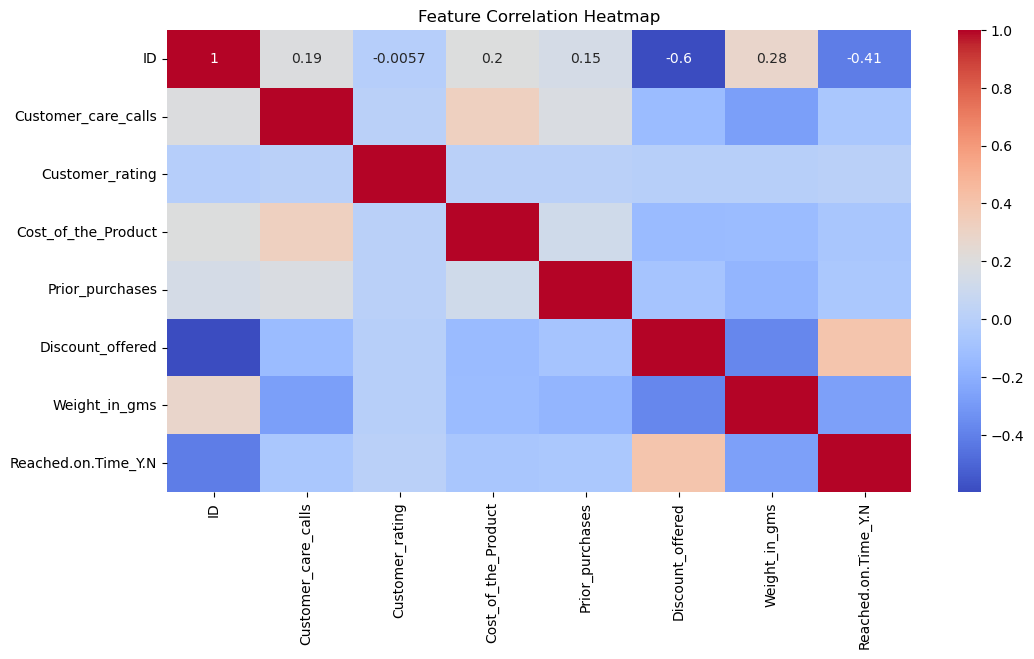

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Encoding categorical features
encoder = LabelEncoder()
categorical_cols = ["Warehouse_block", "Mode_of_Shipment", "Product_importance", "Gender"]
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

In [8]:
# Feature Engineering - Estimated Shipping Cost
df["Estimated_Shipping_Cost"] = (
    df["Weight_in_gms"] * 0.05 + np.where(df["Mode_of_Shipment"] == 0, 50, 10) - df["Discount_offered"] * 0.5
)

def recommend_carrier(row):
    if row["Mode_of_Shipment"] == 0:  # Flight
        return "DHL" if row["Weight_in_gms"] < 1000 else "FedEx"
    elif row["Mode_of_Shipment"] == 1:  # Ship
        return "Maersk"
    else:
        return "Local Truck"

df["Recommended_Carrier"] = df.apply(recommend_carrier, axis=1)

In [9]:
# Save Updated Dataset
df.to_csv("updated_dataset.csv", index=False)

# Reload Updated Dataset
updated_df = pd.read_csv("updated_dataset.csv")

# Encode Recommended Carrier
updated_df["Recommended_Carrier"] = LabelEncoder().fit_transform(updated_df["Recommended_Carrier"])

In [10]:
# Define features and target variables
X = updated_df[["Mode_of_Shipment", "Cost_of_the_Product", "Discount_offered",
                 "Weight_in_gms", "Customer_rating", "Prior_purchases", "Warehouse_block", "Product_importance"]]
y_classification = updated_df["Reached.on.Time_Y.N"]
y_regression = updated_df["Estimated_Shipping_Cost"]
y_carrier = updated_df["Recommended_Carrier"]

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Train-Test Split (Single split for consistency)
X_train, X_test, y_train_cls, y_test_cls, y_train_reg, y_test_reg, y_train_car, y_test_car = train_test_split(
    X, y_classification, y_regression, y_carrier, test_size=0.2, random_state=42
)

In [12]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.ensemble import BalancedRandomForestClassifier
# Use Balanced Random Forest instead of SMOTE
balanced_rf = BalancedRandomForestClassifier()
param_grid_cls = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
delay_model = GridSearchCV(balanced_rf, param_grid_cls, cv=5).fit(X_train, y_train_cls)

In [13]:
# Feature Scaling (Only for Regression and Carrier Models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, precision_recall_curve
# Hyperparameter tuning for regression
param_grid_reg = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
cost_model = GridSearchCV(RandomForestRegressor(), param_grid_reg, cv=5).fit(X_train_scaled, y_train_reg)

# Hyperparameter tuning for carrier selection
param_grid_car = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
carrier_model = GridSearchCV(RandomForestClassifier(), param_grid_car, cv=5).fit(X_train_scaled, y_train_car)

# Model Evaluation
print("Best Parameters (On-Time Prediction):", delay_model.best_params_)
print("Classification Report (On-Time Prediction):")
pred_probs = delay_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_cls, pred_probs)
best_threshold = 0.6  # Adjusted threshold to balance recall and precision
pred_labels = (pred_probs > best_threshold).astype(int)
print(classification_report(y_test_cls, pred_labels))

print("Best Parameters (Shipping Cost Prediction):", cost_model.best_params_)
print("Mean Absolute Error (Shipping Cost Prediction):", mean_absolute_error(y_test_reg, cost_model.predict(X_test_scaled)))

print("Best Parameters (Carrier Selection Prediction):", carrier_model.best_params_)
print("Classification Report (Carrier Selection Prediction):")
print(classification_report(y_test_car, carrier_model.predict(X_test_scaled)))

Best Parameters (On-Time Prediction): {'max_depth': 10, 'n_estimators': 200}
Classification Report (On-Time Prediction):
              precision    recall  f1-score   support

           0       0.57      0.99      0.72       895
           1       0.98      0.49      0.65      1305

    accuracy                           0.69      2200
   macro avg       0.78      0.74      0.69      2200
weighted avg       0.81      0.69      0.68      2200

Best Parameters (Shipping Cost Prediction): {'max_depth': 20, 'n_estimators': 200}
Mean Absolute Error (Shipping Cost Prediction): 0.4055828369695408
Best Parameters (Carrier Selection Prediction): {'max_depth': 10, 'n_estimators': 50}
Classification Report (Carrier Selection Prediction):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       352
           1       1.00      1.00      1.00      1480
           2       1.00      1.00      1.00       368

    accuracy                           1.00 

In [15]:
import joblib
import pickle
# Save Models & Scaler
pickle.dump(delay_model, open("delay_model.pkl", "wb"))
pickle.dump(cost_model, open("cost_model.pkl", "wb"))
pickle.dump(carrier_model, open("carrier_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))

print("Models and scaler saved successfully!")

Models and scaler saved successfully!
